In [1]:
from importlib import reload
import numpy as np
import json
import matplotlib.pyplot as plt
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras import layers

In [9]:
# import modules
import src.models
reload(src.models)
from src.models import *

import src.data_methods
reload(src.data_methods)
from src.data_methods import *

import src.features as features
reload(features)

<module 'src.features' from 'C:\\Users\\Andrew\\Documents\\CeR\\GestRec\\leap_gesture_rec\\src\\features.py'>

In [3]:
gestures, g2idx, idx2g = get_gestures(version=3)

In [ ]:
# if needed, sort out dicts
# X, y = CSV2examples(raw_file='data/recordings/normalization_data.csv', g2idx=g2idx, n_frames=n_frames, target_fps=30, standardize=True, dicts_gen=True, derive_features=True)

In [10]:
n_frames = 40
X, y = folder2examples(folder='data/loopsV3/train/', g2idx=g2idx, n_frames=n_frames, mirror=True)
X_val, y_val = folder2examples(folder='data/loopsV3/test/', g2idx=g2idx, n_frames=n_frames, mirror=True)
print(X.shape)

mean fps: 28.78
target fps: 30
taking every 1 frames
98.72% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.62
target fps: 30
taking every 1 frames
96.23% of rows contain valid LH data
99.16% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.62
target fps: 30
taking every 1 frames
93.07% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
mean fps: 27.61
target fps: 30
taking every 1 frames
96.20% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 49769 rows with nans
{'one_handed': ['adjacent_finger_distances', 'finger_palm_distances', 'finger_palm_plain_distances'], 'two_handed': ['interpalm_distance', 'interfinger_distances']}
dealt with 0 of 49769 rows with nans
Data successfully mirr

In [122]:
model = many2one_model(n_features = X.shape[-1], n_frames=X.shape[1], n_gestures=len(g2idx), n_lstm_layers=1, rnn_units=4, recurrent_dropout=0.0, bidirectional=True)

Model: "many2one"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        [(None, 40, 50)]          0         
_________________________________________________________________
bidirectional_9 (Bidirection (None, 8)                 1760      
_________________________________________________________________
dense_18 (Dense)             (None, 33)                297       
Total params: 2,057
Trainable params: 2,057
Non-trainable params: 0
_________________________________________________________________


In [136]:
opt = tf.keras.optimizers.Adam(learning_rate=0.002)
# opt = tf.keras.optimizers.SGD(learning_rate=0.001)
model.compile(optimizer=opt, loss='sparse_categorical_crossentropy', metrics=['accuracy'])
history = model.fit(X, y, validation_data=(X_val, y_val), epochs=10, batch_size = 50)

Train on 4328 samples, validate on 792 samples
Epoch 1/10
4328/4328 [==============================] - 11s 3ms/sample - loss: 0.0692 - accuracy: 0.9875 - val_loss: 0.6032 - val_accuracy: 0.8965
Epoch 2/10
4328/4328 [==============================] - 3s 599us/sample - loss: 0.0433 - accuracy: 0.9942 - val_loss: 0.5890 - val_accuracy: 0.8990
Epoch 3/10
4328/4328 [==============================] - 3s 694us/sample - loss: 0.0350 - accuracy: 0.9954 - val_loss: 0.5860 - val_accuracy: 0.9003
Epoch 4/10
4328/4328 [==============================] - 3s 709us/sample - loss: 0.0311 - accuracy: 0.9970 - val_loss: 0.5725 - val_accuracy: 0.9040
Epoch 5/10
4328/4328 [==============================] - 3s 702us/sample - loss: 0.0285 - accuracy: 0.9970 - val_loss: 0.5684 - val_accuracy: 0.9053
Epoch 6/10
4328/4328 [==============================] - 3s 691us/sample - loss: 0.0264 - accuracy: 0.9977 - val_loss: 0.5765 - val_accuracy: 0.9040
Epoch 7/10
4328/4328 [==============================] - 3s 710us/s

In [139]:
model.save('models/V3/40f_4hs_bi.h5')

In [49]:
model = tf.keras.models.load_model('models/V3/40f_5hs.h5')

In [24]:
# load test data
X_test, y_test = CSV2examples('recordings/cputest-maxed.csv', g2idx=g2idx, n_frames=40)

mean fps: 20.82
target fps: 25
taking every 1 frames
100.00% of rows contain valid LH data
100.00% of rows contain valid RH data
Found left hand data:  True
Found right hand data:  True
dealt with 0 of 1600 rows with nans
dealt with 0 of 1600 rows with nans
Data successfully mirrored


In [20]:
# predict on a random test case
i = np.random.randint(0, len(X_test))
print(i)
pred = model.predict(np.expand_dims(np.array(X_test[i]), axis=0))
print(pred)
print('Predicted: ', idx2g[np.argmax(pred)])
print('Truth: ', idx2g[y_test[i]])

76
[[5.1329839e-03 1.2742927e-04 1.3233292e-03 8.1423987e-03 3.8563199e-02
  1.0936646e-02 7.2512496e-01 2.1064912e-01]]
Predicted:  shuffle_over
Truth:  shuffle_over


In [54]:
print(idx2g[y[1]])

so_so


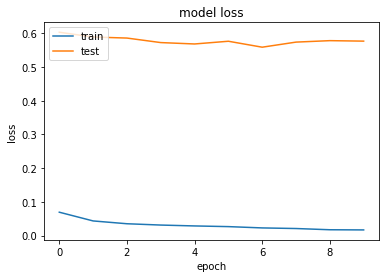

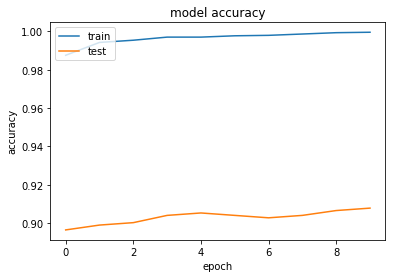

In [137]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [ ]:
# plot history:
plt_metric(history, 'loss')
plt_metric(history, 'accuracy')

In [138]:
# get confusion matrix
pred = np.argmax(model.predict(X_val), axis=-1)

c_matrix = pd.crosstab(y_val, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))

[('middle_finger', 0.04), ('wave', 0.46), ('multiple', 0.75), ('thumbs_up', 0.83), ('small', 0.83), ('smoothing_sand', 0.83), ('counting_hands_together', 0.88), ('finger_drawing', 0.88), ('fist', 0.92), ('gun', 0.92), ('this_big', 0.92), ('driving', 0.92), ('drawing', 0.92), ('peace', 0.96), ('thumbs_down', 0.96), ('typing', 0.96), ('no_gesture', 1.0), ('call_me', 1.0), ('maybe', 1.0), ('ok', 1.0), ('open_close', 1.0), ('pointing', 1.0), ('shuffle_over', 1.0), ('so_so', 1.0), ('stop', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('love_heart_set', 1.0), ('why', 1.0), ('path', 1.0), ('gather_leaves', 1.0), ('robotic_arm', 1.0), ('cup_hands', 1.0)]


Wave and middle finger most urgent, not being recognized at all.
stop and peace, redo. 

In [129]:
# get confusion matrix
pred = np.argmax(model.predict(X), axis=-1)

c_matrix = pd.crosstab(y, pred, rownames=['Actual'], colnames=['Predicted'], normalize='index')

accuracy = {g: 0 for g in g2idx.keys()}
for i in c_matrix.index:
    if i not in c_matrix.columns:
        pass
    else:
        accuracy[idx2g[i]] = round(c_matrix.loc[i,i],2)

print(sorted(accuracy.items(), key=lambda x: x[1]))
    

[('finger_drawing', 0.92), ('small', 0.95), ('multiple', 0.95), ('thumbs_up', 0.96), ('pointing', 0.97), ('thumbs_down', 0.97), ('robotic_arm', 0.97), ('no_gesture', 0.98), ('open_close', 0.98), ('peace', 0.98), ('shuffle_over', 0.98), ('wave', 0.98), ('middle_finger', 0.98), ('smoothing_sand', 0.98), ('call_me', 0.99), ('so_so', 0.99), ('stop', 0.99), ('typing', 0.99), ('counting_hands_together', 0.99), ('path', 0.99), ('drawing', 0.99), ('fist', 1.0), ('gun', 1.0), ('maybe', 1.0), ('ok', 1.0), ('this_big', 1.0), ('triangle_set', 1.0), ('circle_set', 1.0), ('love_heart_set', 1.0), ('driving', 1.0), ('why', 1.0), ('gather_leaves', 1.0), ('cup_hands', 1.0)]


In [21]:
c_matrix.index

Int64Index([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
            17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
           dtype='int64', name='Actual')